# Student name: Menghao Wu; Student ID: 235843440
# Student name: Ren Wei; Student ID: 235841180

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_components_plotly
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from sklearn import preprocessing

In [2]:
min_max_scaler = preprocessing.MinMaxScaler()
def create_prophet(in_data):
    """
        data (pandas.DataFrame): A DataFrame containing the time series data.
         The DataFrame should have a datetime column for timestamps as 'ds'
          and a numeric column for the target variable to forecast as ‘y’.

        Returns:
            tuple: A tuple containing three elements:
                - forecast_data (pandas.DataFrame): A DataFrame with the original data
                                                     merged with the forecast results.
                - model (Prophet): The fitted Prophet model object.
                - forecast (pandas.DataFrame): The raw forecast DataFrame generated by Prophet.
    """
    # loading holiday dataset as a parameter of prophet forecasting
    holiday_data = pd.read_csv('holidays.csv',sep=',', encoding='utf-8')
    holiday_data.dropna(subset=['ds'], inplace=True)
    holiday_data = holiday_data.drop_duplicates(subset=['ds'])
    holiday_data['ds'] = pd.to_datetime(holiday_data['ds'])
    # Create a Prophet model and fit it to the data
    p_model = Prophet(holidays=holiday_data, changepoint_prior_scale=1.4, n_changepoints=26,weekly_seasonality=False, holidays_prior_scale=2.0,yearly_seasonality=10,daily_seasonality=False, changepoint_range=0.8, interval_width=0.8, uncertainty_samples=800)
    # Rename columns for prophet
    prophet_data = in_data.rename(columns={'FXUSDCAD': 'y', 'date' : 'ds'})
    prophet_data = prophet_data.reindex(columns=['ds', 'y'] + [col for col in prophet_data.columns if col not in ['ds', 'y']])
    prophet_data['canada_interest_rate'] = min_max_scaler.fit_transform(prophet_data[['canada_interest_rate']])
    prophet_data['us_interest_rate'] = min_max_scaler.fit_transform(prophet_data[['us_interest_rate']])
    prophet_data['goods_inflation'] = min_max_scaler.fit_transform(prophet_data[['goods_inflation']])
    prophet_data['services_inflation'] = min_max_scaler.fit_transform(prophet_data[['services_inflation']])
    prophet_data['NASDAQCOM'] = min_max_scaler.fit_transform(prophet_data[['NASDAQCOM']])
    
    p_model.add_seasonality(name='weekly_pre_fx', period=7, fourier_order=3)
    p_model.add_seasonality(name='monthly_pre_fx', period=30, fourier_order=4)
    p_model.add_seasonality(name='quarterly_pre_fx', period=91.25, fourier_order=5)
    p_model.add_regressor('canada_interest_rate', prior_scale=0.4)
    p_model.add_regressor('us_interest_rate', prior_scale=0.4)
    p_model.add_regressor('goods_inflation', prior_scale=1.0)
    p_model.add_regressor('services_inflation', prior_scale=1.0)
    p_model.add_regressor('NASDAQCOM', prior_scale=0.0002)
    p_model.fit(prophet_data)
    # Define the future dates for forecasting
    future = p_model.make_future_dataframe(periods=14, freq="D")  # Forecast for 2 weeks
    prophet_data_sorted = prophet_data.sort_values(by='ds', ascending=False)
    future['canada_interest_rate'] = prophet_data_sorted['canada_interest_rate'].iloc[0]
    future['us_interest_rate'] = prophet_data_sorted['us_interest_rate'].iloc[0]
    future['goods_inflation'] = prophet_data_sorted['goods_inflation'].iloc[0]
    future['services_inflation'] = prophet_data_sorted['services_inflation'].iloc[0]
    future['NASDAQCOM'] = prophet_data_sorted['NASDAQCOM'].iloc[0]
    # Generate the forecast
    prophet_forecast = p_model.predict(future)
    prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])
    prophet_forecast['ds'] = pd.to_datetime(prophet_forecast['ds'])
    # merge the forecast as a complete output
    merged_df = pd.merge(prophet_data[['ds', 'y', 'canada_interest_rate', 'us_interest_rate', 'goods_inflation', 'services_inflation', 'NASDAQCOM']], prophet_forecast[['ds', 'yhat']], on='ds', how='inner')
    return merged_df, p_model, prophet_forecast

In [3]:
categories = ['FXUSDCAD']
data = pd.read_csv('group_project_training_dataset_v2.csv',sep=',', encoding='utf-8')
# Drop rows with any nan values
data.dropna(subset=['FXUSDCAD'], inplace=True)
data['canada_interest_rate'] = data['canada_interest_rate'].apply(lambda x: float(x) / 100)
data['us_interest_rate'] = data['us_interest_rate'].apply(lambda x: float(x) / 100)
print("\nSummary of DataFrame:")
print(data.info())


Summary of DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2648 entries, 0 to 2647
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  2648 non-null   object 
 1   us_dollar_index       2648 non-null   float64
 2   FXAUDCAD              2648 non-null   float64
 3   FXCHFCAD              2648 non-null   float64
 4   FXCNYCAD              2648 non-null   float64
 5   FXEURCAD              2648 non-null   float64
 6   FXGBPCAD              2648 non-null   float64
 7   FXJPYCAD              2648 non-null   float64
 8   FXMXNCAD              2648 non-null   float64
 9   FXNZDCAD              2648 non-null   float64
 10  FXSEKCAD              2648 non-null   float64
 11  FXUSDCAD              2648 non-null   float64
 12  canada_interest_rate  2648 non-null   float64
 13  us_interest_rate      2648 non-null   float64
 14  goods_inflation       2648 non-null   float64
 15

In [4]:
from scipy.stats import f_oneway, ttest_ind
# Example ANOVA test for 'canada_interest_rate'
grouped_data = [data[data['us_interest_rate'] < 0.035]['FXUSDCAD'],
                data[(data['us_interest_rate'] >= 0.035) & (data['us_interest_rate'] < 0.05)]['FXUSDCAD'],
                data[data['us_interest_rate'] >= 0.05]['FXUSDCAD']]

anova_result = f_oneway(*grouped_data)
print("ANOVA Results for US Interest Rate:")
print("F-statistic:", anova_result.statistic)
print("p-value:", anova_result.pvalue)

grouped_data2 = [data[data['canada_interest_rate'] < 0.035]['FXUSDCAD'],
                data[(data['canada_interest_rate'] >= 0.035) & (data['canada_interest_rate'] < 0.05)]['FXUSDCAD'],
                data[data['canada_interest_rate'] >= 0.05]['FXUSDCAD']]

anova_result2 = f_oneway(*grouped_data2)
print("ANOVA Results for Canada Interest Rate:")
print("F-statistic:", anova_result2.statistic)
print("p-value:", anova_result2.pvalue)


# Example t-test for 'us_interest_rate'
high_us_rate = data[data['us_interest_rate'] > 0.035]['FXUSDCAD']
low_us_rate = data[data['us_interest_rate'] <= 0.035]['FXUSDCAD']

ttest_result = ttest_ind(high_us_rate, low_us_rate)
print("\nT-test Results for US Interest Rate:")
print("t-statistic:", ttest_result.statistic)
print("p-value:", ttest_result.pvalue)

high_us_rate2 = data[data['canada_interest_rate'] > 0.035]['FXUSDCAD']
low_us_rate2 = data[data['canada_interest_rate'] <= 0.035]['FXUSDCAD']

ttest_result2 = ttest_ind(high_us_rate2, low_us_rate2)
print("T-test Results for Canada Interest Rate:")
print("t-statistic:", ttest_result2.statistic)
print("p-value:", ttest_result2.pvalue)

ANOVA Results for US Interest Rate:
F-statistic: 430.97367089451177
p-value: 9.750586035825059e-163
ANOVA Results for Canada Interest Rate:
F-statistic: 332.0710823043645
p-value: 2.1592700676366033e-129

T-test Results for US Interest Rate:
t-statistic: 16.94659640457657
p-value: 3.0869868986981338e-61
T-test Results for Canada Interest Rate:
t-statistic: 25.75538644447823
p-value: 1.0173441259367976e-130


In [5]:

data_sorted = sorted(data['goods_inflation'])
one_third_point = data_sorted[int(len(data_sorted) / 3)]
print("goods_inflation one_third_point", one_third_point)
two_third_point = data_sorted[int(2 * len(data_sorted) / 3)]
print("goods_inflation two_third_point", two_third_point)
# Example ANOVA test for 'goods_inflation'
grouped_data = [data[data['goods_inflation'] < one_third_point]['FXUSDCAD'],
                data[(data['goods_inflation'] >= one_third_point) & (data['goods_inflation'] < two_third_point)]['FXUSDCAD'],
                data[data['goods_inflation'] >= two_third_point]['FXUSDCAD']]

anova_result = f_oneway(*grouped_data)
print("ANOVA Results for goods inflation:")
print("F-statistic:", anova_result.statistic)
print("p-value:", anova_result.pvalue)


data_sorted2 = sorted(data['services_inflation'])
one_third_point2 = data_sorted2[int(len(data_sorted2) / 3)]
print("services_inflation one_third_point2", one_third_point2)
two_third_point2 = data_sorted2[int(2 * len(data_sorted2) / 3)]
print("services_inflation two_third_point2", two_third_point2)
grouped_data2 = [data[data['services_inflation'] < one_third_point2]['FXUSDCAD'],
                data[(data['services_inflation'] >= one_third_point2) & (data['services_inflation'] < two_third_point2)]['FXUSDCAD'],
                data[data['services_inflation'] >= two_third_point2]['FXUSDCAD']]

anova_result2 = f_oneway(*grouped_data2)
print("ANOVA Results for services_inflation:")
print("F-statistic:", anova_result2.statistic)
print("p-value:", anova_result2.pvalue)


data_sorted3 = sorted(data['us_dollar_index'])
one_third_point3 = data_sorted3[int(len(data_sorted3) / 3)]
print("us_dollar_index one_third_point2", one_third_point3)
two_third_point3 = data_sorted3[int(2 * len(data_sorted3) / 3)]
print("us_dollar_index two_third_point2", two_third_point3)
grouped_data3 = [data[data['us_dollar_index'] < one_third_point3]['FXUSDCAD'],
                data[(data['us_dollar_index'] >= one_third_point3) & (data['us_dollar_index'] < two_third_point3)]['FXUSDCAD'],
                data[data['us_dollar_index'] >= two_third_point3]['FXUSDCAD']]

anova_result3 = f_oneway(*grouped_data3)
print("ANOVA Results for us_dollar_index:")
print("F-statistic:", anova_result3.statistic)
print("p-value:", anova_result3.pvalue)


# Example t-test for 'goods_inflation'
print("goods_inflation median:", data['goods_inflation'].median())
high_us_rate = data[data['goods_inflation'] > data['goods_inflation'].median()]['FXUSDCAD']
low_us_rate = data[data['goods_inflation'] <= data['goods_inflation'].median()]['FXUSDCAD']

ttest_result = ttest_ind(high_us_rate, low_us_rate)
print("\nT-test Results for goods_inflation:")
print("t-statistic:", ttest_result.statistic)
print("p-value:", ttest_result.pvalue)

print("services_inflation median:", data['services_inflation'].median())
high_us_rate2 = data[data['services_inflation'] > data['services_inflation'].median()]['FXUSDCAD']
low_us_rate2 = data[data['services_inflation'] <= data['services_inflation'].median()]['FXUSDCAD']

ttest_result2 = ttest_ind(high_us_rate2, low_us_rate2)
print("T-test Results for services_inflation:")
print("t-statistic:", ttest_result2.statistic)
print("p-value:", ttest_result2.pvalue)


print("us_dollar_index median:", data['us_dollar_index'].median())
high_us_rate3 = data[data['us_dollar_index'] > data['us_dollar_index'].median()]['FXUSDCAD']
low_us_rate3 = data[data['us_dollar_index'] <= data['us_dollar_index'].median()]['FXUSDCAD']

ttest_result3 = ttest_ind(high_us_rate3, low_us_rate3)
print("T-test Results for us_dollar_index:")
print("t-statistic:", ttest_result3.statistic)
print("p-value:", ttest_result3.pvalue)

goods_inflation one_third_point 122.2
goods_inflation two_third_point 130.9
ANOVA Results for goods inflation:
F-statistic: 64.18846822166446
p-value: 6.0074098236210855e-28
services_inflation one_third_point2 149.4
services_inflation two_third_point2 156.7
ANOVA Results for services_inflation:
F-statistic: 60.382005764558535
p-value: 2.2775041260842836e-26
us_dollar_index one_third_point2 94.516
us_dollar_index two_third_point2 99.451
ANOVA Results for us_dollar_index:
F-statistic: 999.0960634418345
p-value: 5e-324
goods_inflation median: 123.3

T-test Results for goods_inflation:
t-statistic: -4.064142578383581
p-value: 4.9613916495938136e-05
services_inflation median: 151.6
T-test Results for services_inflation:
t-statistic: -6.8458969938630725
p-value: 9.411468436722868e-12
us_dollar_index median: 96.5895
T-test Results for us_dollar_index:
t-statistic: 38.21749361531843
p-value: 7.364918283239227e-255


In [6]:
products = []
prophet_models = {}
prophet_merged_results = {}
prophet_forecasts = {}
prophet_residuals = {}
for c in categories:
    product_name = None
    if c in data.columns.tolist():
        merged_result, model, forecast = create_prophet(data)
        prophet_models[c] = model
        prophet_merged_results[c] = merged_result
        prophet_forecasts[c] = forecast
        # compute residuals
        actual_prices = merged_result['y']
        prophet_predicts = merged_result['yhat']
        prophet_residuals[c] = [actual - predict for actual, predict in zip(actual_prices, prophet_predicts)]

print("currency categories:")
print(categories)

16:36:57 - cmdstanpy - INFO - Chain [1] start processing
16:37:00 - cmdstanpy - INFO - Chain [1] done processing


currency categories:
['FXUSDCAD']


FXUSDCAD


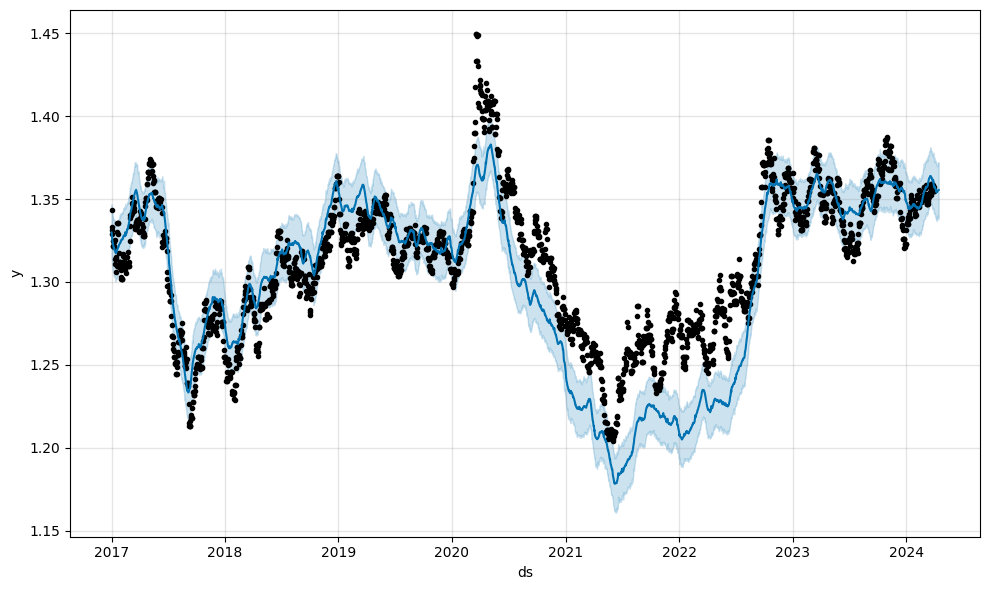

In [7]:
# display the predictions plot
""" the original data, forecasted values, uncertainty intervals of the forecast"""
show_product_name = list(prophet_forecasts.keys())[0]
print(show_product_name)
show_forecast = prophet_forecasts[show_product_name]
show_model = prophet_models[show_product_name]
fig_o = show_model.plot(show_forecast)

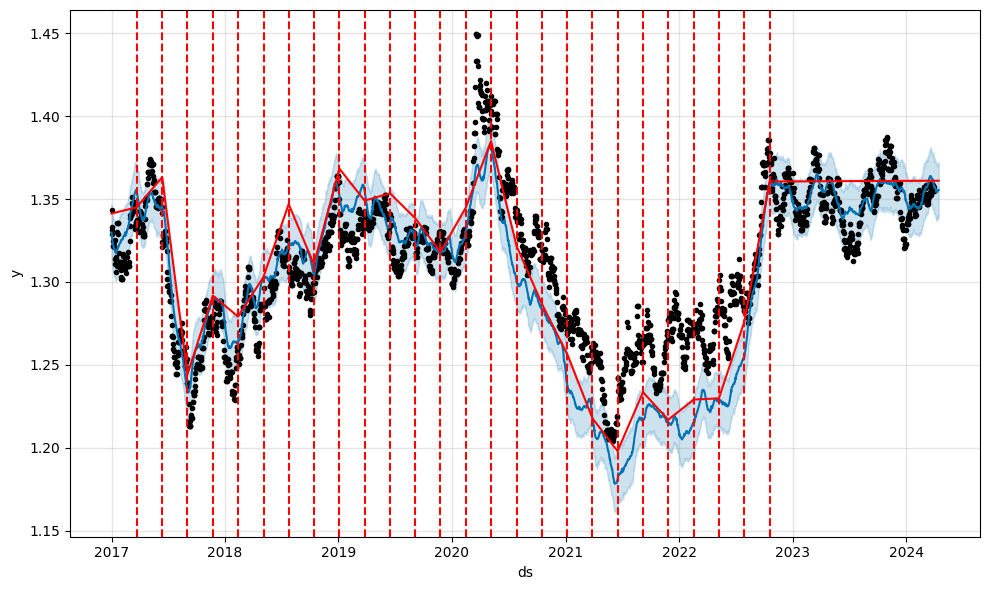

In [8]:
from prophet.plot import add_changepoints_to_plot
fig_cp = show_model.plot(show_forecast)
a = add_changepoints_to_plot(fig_cp.gca(), show_model, show_forecast)

In [9]:
plot_components_plotly(show_model, show_forecast)

In [10]:
# Calculate correlation coefficients
correlation_matrix = prophet_merged_results[categories[0]].corr()

# Extract correlations with the target variable
correlation_with_target = correlation_matrix['y']

# Print correlations
print("Correlation with USD_CAD_exchange_rate:")
print(correlation_with_target)

Correlation with USD_CAD_exchange_rate:
ds                      0.198834
y                       1.000000
canada_interest_rate    0.504070
us_interest_rate        0.510094
goods_inflation         0.213718
services_inflation      0.293120
NASDAQCOM              -0.147447
yhat                    0.881473
Name: y, dtype: float64


In [11]:
prophet_forecasts['FXUSDCAD'].tail(14)

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2648 2024-04-02  1.361037    1.341509    1.374942     1.361037     1.361037   
2649 2024-04-03  1.361037    1.341171    1.372843     1.361037     1.361037   
2650 2024-04-04  1.361038    1.339443    1.372369     1.361038     1.361038   
2651 2024-04-05  1.361039    1.339368    1.373129     1.361039     1.361039   
2652 2024-04-06  1.361040    1.338015    1.371907     1.361040     1.361040   
2653 2024-04-07  1.361041    1.337484    1.371428     1.361041     1.361041   
2654 2024-04-08  1.361042    1.337559    1.370766     1.361042     1.361042   
2655 2024-04-09  1.361042    1.336822    1.370146     1.361042     1.361042   
2656 2024-04-10  1.361043    1.338996    1.369853     1.361043     1.361043   
2657 2024-04-11  1.361044    1.337660    1.370450     1.361044     1.361044   
2658 2024-04-12  1.361045    1.340225    1.371952     1.361045     1.361045   
2659 2024-04-13  1.361046    1.337977    1.371379     1.361046     1.361046   
2660 2024-04-14  1.361046    1.338741    1.372256     1.361046     1.361046   
2661 2024-04-15  1.361047    1.338444    1.371278     1.361047     1.361047   

      NASDAQCOM  NASDAQCOM_lower  NASDAQCOM_upper  additive_terms  ...  \
2648  -0.001585        -0.001585        -0.001585       -0.003553  ...   
2649  -0.001585        -0.001585        -0.001585       -0.004165  ...   
2650  -0.001585        -0.001585        -0.001585       -0.004291  ...   
2651  -0.001585        -0.001585        -0.001585       -0.004894  ...   
2652  -0.001585        -0.001585        -0.001585       -0.005490  ...   
2653  -0.001585        -0.001585        -0.001585       -0.006155  ...   
2654  -0.001585        -0.001585        -0.001585       -0.007019  ...   
2655  -0.001585        -0.001585        -0.001585       -0.006507  ...   
2656  -0.001585        -0.001585        -0.001585       -0.006854  ...   
2657  -0.001585        -0.001585        -0.001585       -0.006438  ...   
2658  -0.001585        -0.001585        -0.001585       -0.006240  ...   
2659  -0.001585        -0.001585        -0.001585       -0.005879  ...   
2660  -0.001585        -0.001585        -0.001585       -0.005567  ...   
2661  -0.001585        -0.001585        -0.001585       -0.005557  ...   

      weekly_pre_fx  weekly_pre_fx_lower  weekly_pre_fx_upper    yearly  \
2648       0.000315             0.000315             0.000315  0.066056   
2649      -0.000042            -0.000042            -0.000042  0.065121   
2650       0.000161             0.000161             0.000161  0.063765   
2651       0.000030             0.000030             0.000030  0.062005   
2652       0.000022             0.000022             0.000022  0.059863   
2653      -0.000046            -0.000046            -0.000046  0.057365   
2654      -0.000439            -0.000439            -0.000439  0.054541   
2655       0.000315             0.000315             0.000315  0.051425   
2656      -0.000042            -0.000042            -0.000042  0.048052   
2657       0.000161             0.000161             0.000161  0.044461   
2658       0.000030             0.000030             0.000030  0.040690   
2659       0.000022             0.000022             0.000022  0.036780   
2660      -0.000046            -0.000046            -0.000046  0.032772   
2661      -0.000439            -0.000439            -0.000439  0.028706   

      yearly_lower  yearly_upper  multiplicative_terms  \
2648      0.066056      0.066056                   0.0   
2649      0.065121      0.065121                   0.0   
2650      0.063765      0.063765                   0.0   
2651      0.062005      0.062005                   0.0   
2652      0.059863      0.059863                   0.0   
2653      0.057365      0.057365                   0.0   
2654      0.054541      0.054541                   0.0   
2655      0.051425      0.051425                   0.0   
2656      0.048052      0.048052                   0.0   
2657      

FXUSDCAD


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/37 [00:00<?, ?it/s]

16:37:05 - cmdstanpy - INFO - Chain [1] start processing
16:37:06 - cmdstanpy - INFO - Chain [1] done processing
16:37:06 - cmdstanpy - INFO - Chain [1] start processing
16:37:07 - cmdstanpy - INFO - Chain [1] done processing
16:37:07 - cmdstanpy - INFO - Chain [1] start processing
16:37:11 - cmdstanpy - INFO - Chain [1] done processing
16:37:11 - cmdstanpy - INFO - Chain [1] start processing
16:37:13 - cmdstanpy - INFO - Chain [1] done processing
16:37:13 - cmdstanpy - INFO - Chain [1] start processing
16:37:14 - cmdstanpy - INFO - Chain [1] done processing
16:37:14 - cmdstanpy - INFO - Chain [1] start processing
16:37:15 - cmdstanpy - INFO - Chain [1] done processing
16:37:15 - cmdstanpy - INFO - Chain [1] start processing
16:37:16 - cmdstanpy - INFO - Chain [1] done processing
16:37:17 - cmdstanpy - INFO - Chain [1] start processing
16:37:18 - cmdstanpy - INFO - Chain [1] done processing
16:37:18 - cmdstanpy - INFO - Chain [1] start processing
16:37:19 - cmdstanpy - INFO - Chain [1]

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 12 days  0.000693  0.026332  0.020673  0.015727  0.012963  0.015778   
1 13 days  0.000795  0.028199  0.022278  0.016952  0.014172  0.017005   
2 14 days  0.000899  0.029986  0.023771  0.018091  0.015387  0.018146   
3 15 days  0.001018  0.031901  0.025303  0.019258  0.017003  0.019316   
4 16 days  0.001147  0.033860  0.026814  0.020409  0.017742  0.020469   

   coverage  
0  0.290541  
1  0.261261  
2  0.240991  
3  0.220721  
4  0.211712  


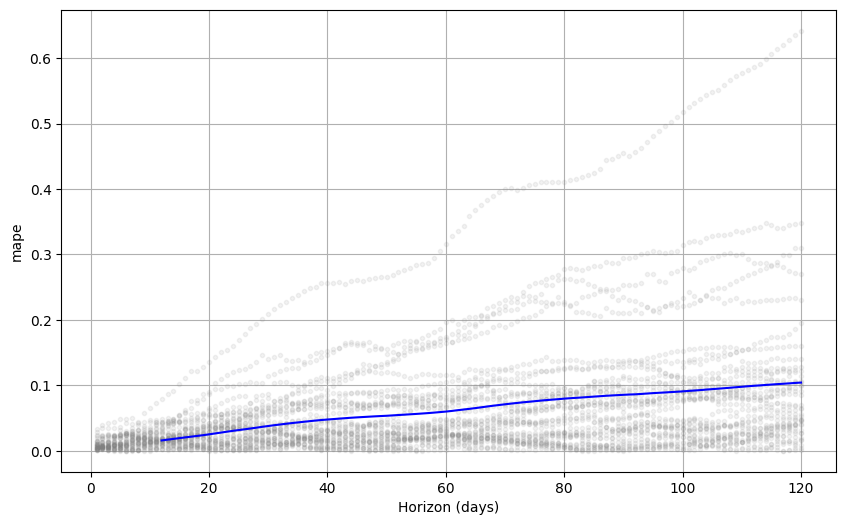

In [12]:
# performs cross-validation on the fitted prophet model
"""" 
    initial: size of the initial training period
    period: spacing between cutoff dates
    horizon: the forecast horizon
"""
for p, m in prophet_models.items():
    print(p)
    df_cv = cross_validation(m, initial='365 days', period='60 days', horizon='120 days')
    df_perf_metrics = performance_metrics(df_cv)
    print(df_perf_metrics.head())
    fig_obj = plot_cross_validation_metric(df_cv, metric='mape')

In [13]:
# verify if TensorFlow will utilize the GPU for the model training
import tensorflow as tf
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


In [14]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

# prepare for LSTM input sequence
def prepare_sequences(residual_data, sequence_length, add_reg, p_name):
    """
    Inputs:
    residual data: a list contains the residual data calculated from the previous prophet model forecasting.
    sequence_length: num of steps to look back (how many past data points the LSTM will consider as input for its prediction)
    add_reg: additive regressors added to the residual data
    p_name: name of the prophet model
    
    Returns:
        tuple: A tuple containing three elements:
            - forecast_data (pandas.DataFrame): A DataFrame with the original data
                                                 merged with the forecast results.
            - model (Prophet): The fitted Prophet model object.
            - forecast (pandas.DataFrame): The raw forecast DataFrame generated by Prophet.
    """
    X = []
    y = []
    if len(residual_data) < sequence_length:
        print("currency type: ",p_name)
        raise Exception("len(residual_data) must be greater than sequence_length")
    for i in range(len(residual_data) - sequence_length):
        X.append(np.concatenate((np.array(residual_data[i:i+sequence_length]).reshape(-1, 1), add_reg[i:i+sequence_length]), axis=1))
        y.append(residual_data[i+sequence_length])
    return np.array(X), np.array(y)

# LSTM model architecture
def create_lstm_model(n_steps, n_features):
    """
    Inputs:
            - n_steps: how many past data points the LSTM will consider as input for its prediction
            - n_features: number of features in the input sequence

    Returns:
            - model (LSTM): The fitted LSTM model instance
    """
    lstm_model = Sequential()
    lstm_model.add(Bidirectional(LSTM(units=64,activation='tanh', return_sequences=True, kernel_regularizer=l2(0.02))))
    # dropout or L2 regularization to help prevent the model from memorizing the training data
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Bidirectional(LSTM(units=32,activation='tanh', return_sequences=True, kernel_regularizer=l2(0.01))))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Bidirectional(LSTM(units=32,activation='tanh', return_sequences=True, kernel_regularizer=l2(0.01))))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(units=1))
    # Mean Squared Error: measure of overall forecasting error
    lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
    return lstm_model

In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# num of steps to look back
n_steps = 90
# num of features
n_features = 6
# num of training epochs
n_epochs = 60

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=0, restore_best_weights=True)

lstm_models = {}
refined_forecasts = {}

for c in categories:
    residual = prophet_residuals[c]
    
    prophet_merged_results[c]['canada_interest_rate'] = min_max_scaler.fit_transform(prophet_merged_results[c][['canada_interest_rate']])
    prophet_merged_results[c]['us_interest_rate'] = min_max_scaler.fit_transform(prophet_merged_results[c][['us_interest_rate']])
    prophet_merged_results[c]['goods_inflation'] = min_max_scaler.fit_transform(prophet_merged_results[c][['goods_inflation']])
    prophet_merged_results[c]['services_inflation'] = min_max_scaler.fit_transform(prophet_merged_results[c][['services_inflation']])
    prophet_merged_results[c]['NASDAQCOM'] = min_max_scaler.fit_transform(prophet_merged_results[c][['NASDAQCOM']])
    
    additional_regressors = prophet_merged_results[c][['canada_interest_rate', 'us_interest_rate', 'goods_inflation', 'services_inflation', 'NASDAQCOM']].values

    X_train, y_train = prepare_sequences(residual, n_steps, additional_regressors, c)
    # Reshape input to be [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    # Create and compile LSTM model
    lstm_model = create_lstm_model(n_steps, n_features)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, train_size=0.7, random_state=42)
    
    model_path = f'{c}_model.tf'
    model_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, verbose=0)

    # Train LSTM model
    lstm_model.fit(X_train, y_train,
                   epochs=n_epochs,
                   batch_size=32,
                   validation_data=(X_val, y_val),
                   verbose=0,
                   callbacks=[model_checkpoint, early_stopping])

    val_loss_train, train_mae, train_mse = lstm_model.evaluate(X_train, y_train)
    print("training Loss: ", val_loss_train)
    print("training Mean Absolute Error:", train_mae)
    print("training Mean Squared Error:", train_mse)   
    val_loss_test, test_mae, test_mse = lstm_model.evaluate(X_val, y_val)
    print("Validation Loss: ", val_loss_test)
    print("Validation Mean Absolute Error:", test_mae)
    print("Validation Mean Squared Error:", test_mse)
    
    lstm_models[c] = lstm_model
    
    future_residuals = []
    
    # concat residuals and additional regressors
    residual_and_add_reg = np.concatenate((np.array(residual).reshape(-1, 1), additional_regressors), axis=1)

    last_residuals = np.array(residual_and_add_reg[-n_steps:]).reshape((1, n_steps, n_features))
    for i in range(len(prophet_forecasts[c])):
        # Predict next residual using the LSTM model
        next_residual = lstm_model.predict(last_residuals)[0, 0]
        future_residuals.append(next_residual)
        
        # Update 'last_residuals' by removing the first element and appending the predicted residual
        last_residuals = np.roll(last_residuals, -1, axis=1)
        last_residuals[0, -1, 0] = next_residual
        
    local_forecast = prophet_forecasts[c]
    # enhance forecasting results by adding residuals
    refined_forecast = np.array(local_forecast['yhat']) + np.array(future_residuals)
    refined_forecasts[c] = refined_forecast

2024-04-11 17:05:06.853322: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-11 17:05:06.853483: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-11 17:05:06.853498: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-11 17:05:06.853976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-11 17:05:06.855317: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-04-11 17:05:12.532276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-11 17:05:13.248851: I te

INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets


INFO:tensorflow:Assets written to: FXUSDCAD_model.tf/assets
2024-04-11 17:10:18.673451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-11 17:10:18.910316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-11 17:10:18.923811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-11 17:10:19.061914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-11 17:10:19.074694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/56 [..............................] - ETA: 1:18 - loss: 7.0027e-04 - mae: 0.0230 - mse: 7.0027e-04

2024-04-11 17:10:19.186377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-11 17:10:19.199202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 5s 66ms/step - loss: 6.4312e-04 - mae: 0.0214 - mse: 6.4312e-04
training Loss:  0.0006431190413422883
training Mean Absolute Error: 0.0213851947337389
training Mean Squared Error: 0.0006431167130358517
24/24 [==============================] - 1s 47ms/step - loss: 6.5219e-04 - mae: 0.0215 - mse: 6.5218e-04
Validation Loss:  0.0006521869800053537
Validation Mean Absolute Error: 0.021474329754710197
Validation Mean Squared Error: 0.000652184768114239


2024-04-11 17:10:24.969841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-11 17:10:25.167039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-11 17:10:25.179468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-11 17:10:25.298819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-11 17:10:25.312758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-04-11 17:10:25.416179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-11 17:10:25.430077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 36ms/step


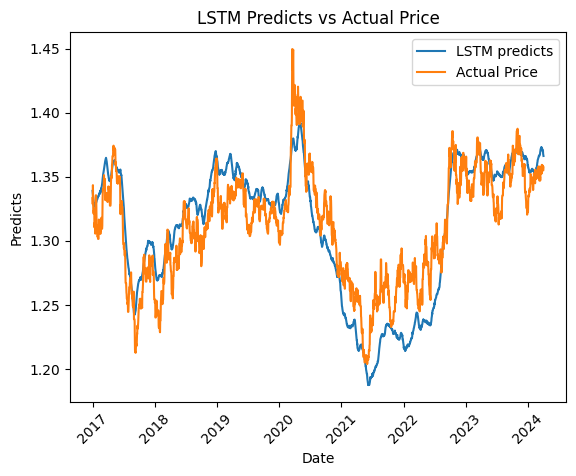

In [17]:
len_p = len(prophet_merged_results[categories[0]])
common_index =prophet_merged_results[categories[0]]['ds']

# Adjust lengths of LSTM predictions to match the lengths of Prophet residuals
refined_predict = pd.Series(refined_forecasts[categories[0]][0][:len_p])
plt.plot(common_index, refined_predict, label='LSTM predicts')
plt.plot(prophet_merged_results[categories[0]]['ds'], prophet_merged_results[categories[0]]['y'], label='Actual Price')
plt.xlabel('Date')
plt.ylabel('Predicts')
plt.title('LSTM Predicts vs Actual Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()

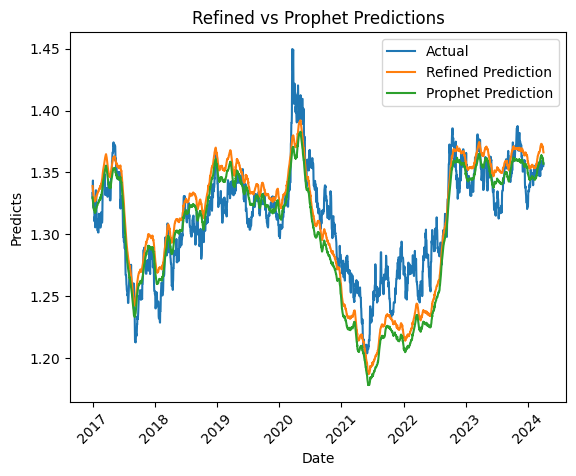

In [18]:
# Adjust lengths of LSTM predictions to match the lengths of Prophet residuals
refined_predict = pd.Series(refined_forecasts[categories[0]][0][:len_p])

# Plot residuals against the 'ds' column
# plt.plot(common_index, prophet_merged_results[products[1]]['y'], label='Actual Price')
plt.plot(common_index, prophet_merged_results[categories[0]]['y'], label='Actual')
plt.plot(common_index, refined_predict, label='Refined Prediction')
plt.plot(common_index, prophet_merged_results[categories[0]]['yhat'], label='Prophet Prediction')
plt.xlabel('Date')
plt.ylabel('Predicts')
plt.title('Refined vs Prophet Predictions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()

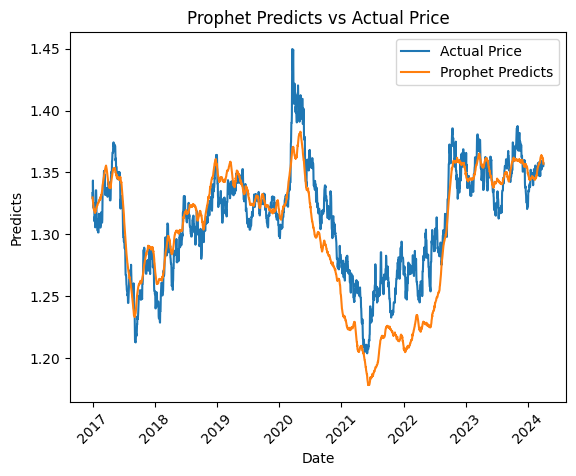

In [19]:
plt.plot(prophet_merged_results[categories[0]]['ds'], prophet_merged_results[categories[0]]['y'], label='Actual Price')
plt.plot(prophet_merged_results[categories[0]]['ds'], prophet_merged_results[categories[0]]['yhat'], label='Prophet Predicts')
plt.xlabel('Date')
plt.ylabel('Predicts')
plt.title('Prophet Predicts vs Actual Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()

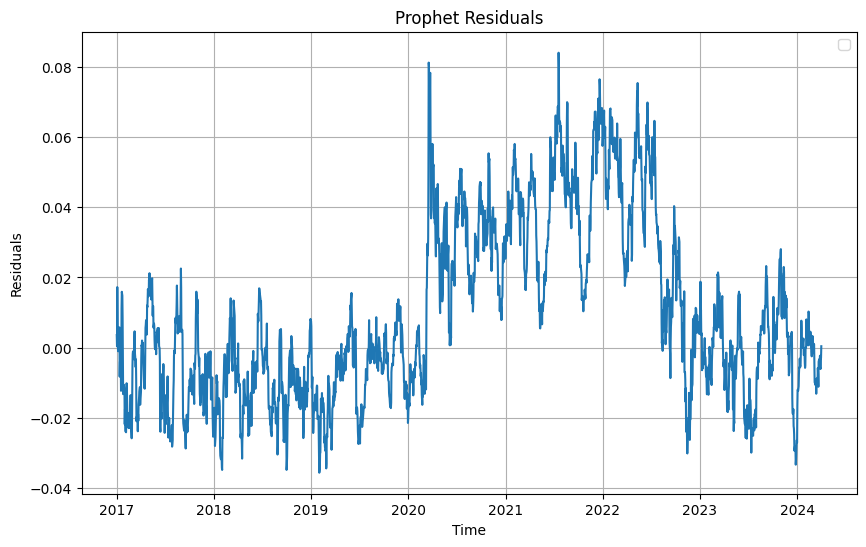

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(prophet_merged_results['FXUSDCAD']['ds'], prophet_residuals['FXUSDCAD'])
plt.title('Prophet Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

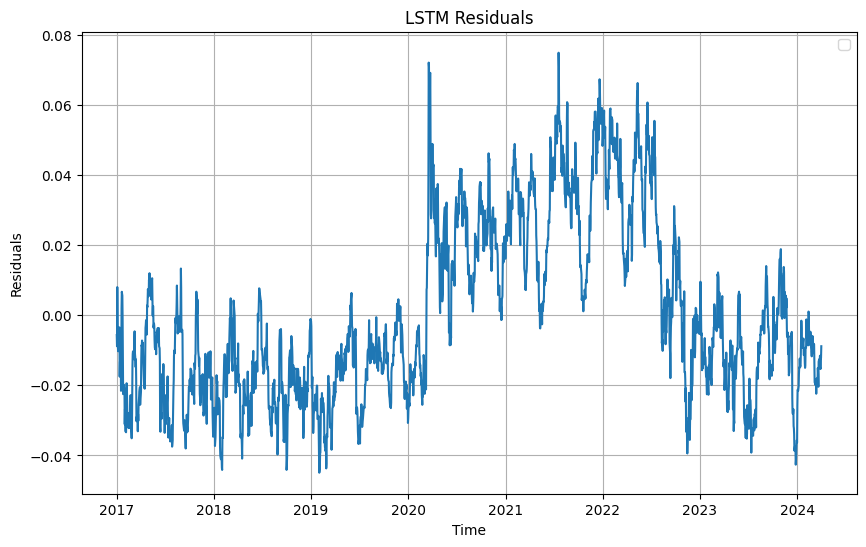

In [21]:
LSTM_residuals = {}
actual_prices = prophet_merged_results['FXUSDCAD']['y']
LSTM_residuals['FXUSDCAD'] = [actual - predict for actual, predict in zip(actual_prices, refined_forecasts['FXUSDCAD'][0][:len_p])]
# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.plot(prophet_merged_results['FXUSDCAD']['ds'], LSTM_residuals['FXUSDCAD'])
plt.title('LSTM Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

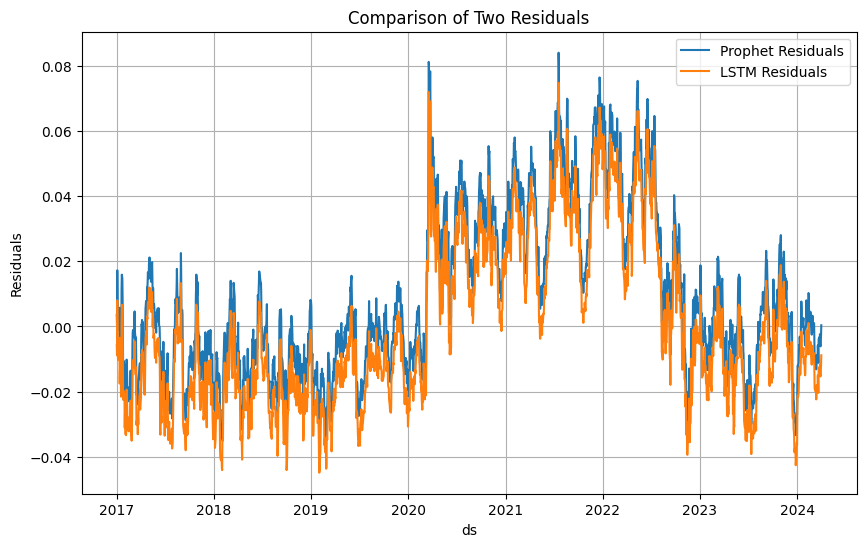

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(prophet_merged_results['FXUSDCAD']['ds'], prophet_residuals['FXUSDCAD'], label='Prophet Residuals')
plt.plot(prophet_merged_results['FXUSDCAD']['ds'], LSTM_residuals['FXUSDCAD'], label='LSTM Residuals')
plt.title('Comparison of Two Residuals')
plt.xlabel('ds')
plt.ylabel('Residuals')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [23]:
threshold = 0.04
prophet_count = 0
lstm_count = 0

# Iterate through Prophet residuals and count how many are closer to 0
for residual in prophet_residuals['FXUSDCAD']:
    if abs(residual) < threshold:
        prophet_count += 1

# Iterate through LSTM residuals and count how many are closer to 0
for residual in LSTM_residuals['FXUSDCAD']:
    if abs(residual) < threshold:
        lstm_count += 1

# Print the counts
print("Number of Prophet residuals closer to 0:", prophet_count)
print("Number of LSTM residuals closer to 0:", lstm_count)

Number of Prophet residuals closer to 0: 2222
Number of LSTM residuals closer to 0: 2382
